# Short tutorial on recurrent nets with Keras.

If you want to clone this Notebook:

```
git clone https://git.fmrib.ox.ac.uk/saad/AnalysisGroup-Educational.git
```

A feed-forward layer looks like this:

                           Input -> Layer -> Output

A recurrent layer looks like this:

                          Input -> Layer -> Output
                                /\       |
                                 |_______|

The only difference is the path looping back from the output to the input of the layer. It is this loop which acts as a form of "memory".

You can have more that one recurrent layer in the middle, which would make these deep.

### To clarify what is meant by the loop it is useful to look at the same network for different input:

![diagram](rnn_diagram.png)


#### Straight away we can see that this type of network assumes the data come in a certain order (like time series)

The red arrows signify that the output of the layer gets passed on to that same layer and combined with a new input. 

##### Different recurrent layers have different ways of combining the red arrow with the input

For example, Simple (vanilla) RNN layers do the following:

    * Multiply the output of the layer by some matrix of weights
    * Multiply the input by another matrix of weights
    * Add the two together
    * Apply a nonlinear function 
    
Here we will learn about vanilla RNNs and a bit about the more popular LSTMs. 

Before we build a RNN, let us first build a feedforward network so we can get familiar with some Keras syntax.

---

## Part 0. Feedforward net

Let's first build a feedforward network (FFN) and then contrast it with a recurrent net (RNN)


In [1]:
# Shortest way to define a feedforward (sequential) model in Keras
from keras.models import Sequential
from keras.layers import Dense

ffn = Sequential(name='FNN')
ffn.add( Dense(units=10, name='layer1', activation='linear', input_shape=(1,)))
ffn.add( Dense(units=1 , name='output'))


Using TensorFlow backend.


* We have created a Input->Layer->Output model. 
* The input and output are 1 dimensional (can you see where we have specified that in the code?)
* The intermediate layer's nonlinear "activation" is just linear (to keep it simple)
* The output layer has default nonlinearity, which is that it is linear


In [2]:
# Display summary of network
ffn.summary()

Model: "FNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 10)                20        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


#### The network has 31 free parameters 
* Why 31? 
    * from input->layer1 we have 10 weights and 10 biases ( layer(i) = w(i)*input+b(i) ) 
    * from layer1->output we have 10 weights and 1 bias ( output = sum(w(i)*layer(i))+b ) 
    * so the total is 31



# Part 1. Basic understanding of RNNs

Now let's create a RNN that is almost the same as our FFN, but has an additional recurrent set of weights.

In [3]:
from keras.layers import SimpleRNN, TimeDistributed

rnn = Sequential(name='vanilla-RNN')
rnn.add( SimpleRNN(units=10, return_sequences=True,
                   activation='linear',input_shape=(20,1,)))

rnn.add( TimeDistributed(Dense(units=1)))

rnn.summary()

Model: "vanilla-RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 10)            120       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 1)             11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


### So what is different in our simple RNN?

#### Number of parameters

We saw earlier how to calculate the 31 parameters of this model (1x10 weights, 10 biases, and another 10x1 weights and 1 bias for the output)

The extra 100 parameters in the RNN are the recurrent weight matrix. Since we have 10 units in the layer, the matrix is 10x10, which gives 131 total. Simple!


#### input_shape

This has an extra element (set here to =20). It is the number of sequential data points that are considered in doing either a forward prediction or in the optimization (gradient calculations). 


#### return_sequences

Flag to say whether we want the output at each of the 20 time points or just at the last time point. This should be set to true when stacking multiple RNNs.

#### TimeDistributed wrapper

This applies the final layer to all the 20 different outputs. 




## The picture below may help understand these last two things


![return_sequences](return_sequences.png)


### But I forget! Let's import numpy and matplotlib - very useful!

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np


### RNNs have a memory 

To understand what is meant by memory, it is useful to look at our RNN's "impule response". 

Let's create an input that looks like a delta function at time=0 and look at the network outputs through time. 


In [5]:
delta = np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

# Note: input must be 3D: batch_size X time_steps X features
# Also note: we have not trained our RNN, so the output is kind of random
# as all the weights are initialised to random values
out_rnn=rnn.predict(delta.reshape((1,-1,1)))   

# Note: output here also has 20 time steps because of TimeDistributed wrapper
print(out_rnn.shape)


(1, 20, 1)


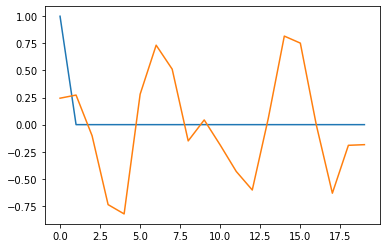

In [6]:
# Plot the output to a delta function:
plt.plot(delta)
plt.plot(out_rnn.flatten())



### As you can see, despite the fact that the network only receives a single pulse at time=0, the ouput has 'reverberations', i.e. a trace of the pulse that persists throughout time.

Let us contrast this with the Feedforward network:




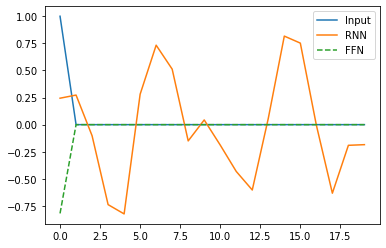

In [8]:

out_ffn = ffn.predict(delta)

plt.figure()
plt.plot(delta)
plt.plot(out_rnn.flatten())
plt.plot(out_ffn,'--')
plt.legend(('Input','RNN','FFN'))

As you can see, the FFN has zero output for zero input (no memory, and the bias is zero by default). The network weights can be negative though. 


By contrast, the FNN can have non-zero output for zero input, because it has an "extra input" from the previous input.

### Now let us understand the output of the RNN a little better by trying to reproduce it with a For Loop:



In [14]:
# Some code to help understand what rnn.get_weights() produces
weights = rnn.get_weights()
for w in weights:
    print(w.shape)
    print(w)


(1, 10)
[[ 0.4287755   0.7145198  -0.23232603  0.17543387  0.5033551  -0.7340704
   0.08123732 -0.33773628  0.5486688   0.34962612]]
(10, 10)
[[-0.6387309   0.35198882  0.13455509  0.08335667 -0.33715874 -0.156373
  -0.43387973 -0.02207934 -0.32847115  0.09117233]
 [ 0.27294794  0.04063416  0.6648276   0.207782   -0.32858142  0.06387559
   0.3537791   0.06553997 -0.21992804  0.38575882]
 [-0.09663907 -0.41780415  0.6591699  -0.03144665  0.28032503 -0.23073708
  -0.3056541  -0.11286336  0.13811596 -0.3514917 ]
 [ 0.03207045  0.60543615  0.10491677  0.08598256  0.57328457 -0.40637445
   0.25542948 -0.22556822 -0.06321955  0.01003291]
 [-0.04695927  0.42915967  0.2721481  -0.2807749   0.01626359  0.67195785
  -0.09821431 -0.22489887  0.37627053 -0.08438437]
 [-0.37019113 -0.16323154 -0.06647581  0.7656913   0.10461011  0.20617713
   0.17332591 -0.22437379  0.31973714  0.09768421]
 [-0.32709658 -0.09141921  0.08780241 -0.20562331  0.4298164   0.09107614
   0.00503816  0.5896201   0.1366756

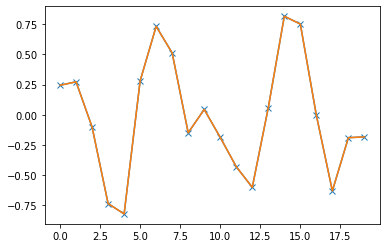

In [19]:
# Reproducing the output of rnn.predict()
# with our own loop through time

# Note: all biases are initialised to zero 
# so we only have matrix multiplications

W1 = rnn.get_weights()[0]   # Input weights
V  = rnn.get_weights()[1]   # Recurrent matrix
W2 = rnn.get_weights()[-2]  # Output weights

L      = np.zeros((1,10))      # 10 units
my_out = np.zeros((20))        # 20 time points
for i in range(20):
    input = delta[i] 
    L = (W1*input + L@V)     # A feedforward network would not have L@V here
    my_out[i] = L@W2         # Output
    

# Compare ours to the network's pred
plt.figure()
plt.plot(out_rnn.flatten(),marker='x')
plt.plot(my_out)



#### One question you may ask is why does the memory persist for so long, why does it not die out? -- Good question.!!!!


The reason is that our network is linear (see the activation function we defined above). So each recurrent operation just multiplies by the same matrix over and over. Now for a general matrix, this will ake some of it explode and some go to zero, but by default in Keras, the RNN is initialised with matrix whose eigenvalues all have unit norm (like rotation matrices). This means the "energy" of the input does not get dissipated by repeatedly multiplying by the weight matrix V above.  



Let's do the same stuff but with a nonlinear activation


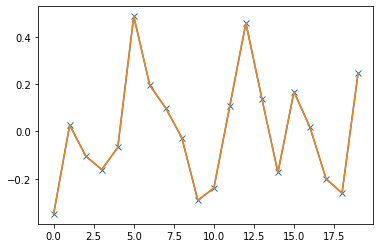

In [20]:
rnn2 = Sequential(name='vanilla-RNN2')
rnn2.add( SimpleRNN(units=10, return_sequences=True,
                   activation='tanh',input_shape=(20,1)))

rnn2.add( TimeDistributed(Dense(units=1,activation='linear')))

W1 = rnn2.get_weights()[0]   # Input weights
V  = rnn2.get_weights()[1]   # Recurrent matrix
W2 = rnn2.get_weights()[-2]  # Output weights

L      = np.zeros((1,10))      # 10 units
my_out = np.zeros((20))        # 20 time points
for i in range(20):
    input = delta[i] 
    L = np.tanh(W1*input + L@V)     # A feedforward network would not have L@V here
    my_out[i] = L@W2         # Output
    
# Compare ours to the network's pred
out_rnn2 = rnn2.predict(delta.reshape((1,-1,1)))
plt.plot(out_rnn2[0,:,0],marker='x')
plt.plot(my_out)



### Superb.




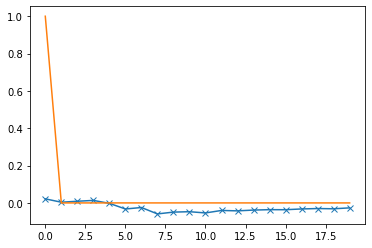

In [102]:

## BELOW: Copy of the code from the above cells
## Run this with different activations, units, etc.

# Redefined RNN with different recurrent activation

units      = 10
activation = 'relu'

rnn = Sequential()
rnn.add( SimpleRNN(units=units, return_sequences=True,
                   activation=activation,input_shape=(20,1)))
rnn.add( SimpleRNN(units=units, return_sequences=True,
                   activation=activation,input_shape=(20,1)))
rnn.add( SimpleRNN(units=units, return_sequences=True,
                   activation=activation,input_shape=(20,1)))
rnn.add( SimpleRNN(units=units, return_sequences=True,
                   activation=activation,input_shape=(20,1)))
rnn.add( SimpleRNN(units=units, return_sequences=True,
                   activation=activation,input_shape=(20,1)))
rnn.add( TimeDistributed(Dense(units=1)))
# Predict output
out_rnn = rnn.predict(delta.reshape((1,-1,1)))

# Compare ours to the network's pred
plt.figure()
plt.plot(out_rnn.flatten(),marker='x')
plt.plot(delta)



### If you have played with the code above a little, you should have noticed that the ReLu activation is very good at dampening the input signal and thus shorten the memory (because it is quite easy for input to end up on the wrong end of a ReLu).

### Also when deepening the network, some strange things happen.


### An interesting remark about memory:

Can we say what the memory of this RNN is? Let's plot the output to different scaled delta functions:


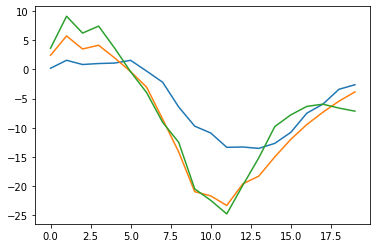

In [67]:
plt.plot(rnn.predict(delta.reshape((1,-1,1))).flatten())
plt.plot(rnn.predict(10*delta.reshape((1,-1,1))).flatten())
plt.plot(rnn.predict(20*delta.reshape((1,-1,1))).flatten())




So the network memory depends on the inout magnitude. But this is just the same as saying the memory depends on the weight matrices. 

In more interesting applications where the input is multidimensional (rather than 1D like here), each dimension can thus have its own memory, and therefore the memory depends on the input (not just the input magnitude, but also the input 'direction'). 


## Gated recurrent nets

Gated recurrent nets are those where the input and the recurrent connection (the red arrow in our diagram at the top) are combined in a more complicated way that in the vanilla RNN. 

In the vanilla RNN, the input and recurrent output are just added to each other.

In gated RNN, they can be combined in nonlinear ways, which makes the behaviour of the memory potentially more complicated.

In Keras, it is easy to implement your own gated RNN. If you do so, make sure you give it a proper 3 or 4 letter acronym.

## LSTMs

LSTM stands for Long and Short term memory.

It is a special case of the so called "Gated" recurrent nets.

You can find decriptions of the way LSTMs do this combination on the interweb. Here we will instead just examine the memory behaviour of LSTMs.


In [68]:
from keras.layers import LSTM

lstm = Sequential()
lstm.add( LSTM(units=10, return_sequences=True,
                   activation='tanh',input_shape=(20,1)))

lstm.add( TimeDistributed(Dense(units=1)))

lstm.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 10)            480       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 20, 1)             11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


#### We have only changed one word, and we have ended up with 491 parameters!

* This is because the LSTM gating has multiple weight matrices for the multiple ways in which the input is combined with the recurrent output.

* Since we are not aiming to describe what LSTMs have under their bonnet, we are not going to try to calculate the number of parameters

#### Let's look at the impulse response 

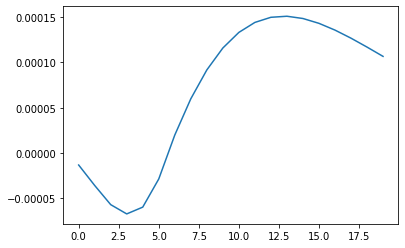

In [109]:

activation = 'relu'

lstm = Sequential()
lstm.add( LSTM(units=10, return_sequences=True,
               activation=activation,input_shape=(20,1)))
lstm.add( LSTM(units=10, return_sequences=True,
               activation=activation,input_shape=(20,1)))
lstm.add( LSTM(units=10, return_sequences=True,
               activation=activation,input_shape=(20,1)))
lstm.add( LSTM(units=10, return_sequences=True,
               activation=activation,input_shape=(20,1)))

lstm.add( TimeDistributed(Dense(units=1)))


plt.plot(lstm.predict(delta.reshape((1,-1,1))).flatten())


### If you play with the code above a little (running it for different network instantiations and for different activations, you should notice that:

* The memory is always nice a smooth and dies out eventually
* This makes them easier to train with backpropagation than vanilla RNNs
* Sometimes you have memories that peak late. This is what is meant by short and long term: depending on the weights AND the input, you can have traces of the input that die out or produce an 'echo'
---

# Part 2: Fitting RNNs to data

So far we've only played with networks with random weights. In applications we fit those weights to data. And so the behaviour of the networks (e.g. memory) is data dependent.

We will fit a simple a sine function.

#### Note: although the more interesting applications are perhaps language modelling, the maths and the understanding is the same as for 1D signal, but there is a lot more overhead in terms of e.g. turning the text into numbers, which gets in the way of understanding the networks. So we won't be doing text modelling here.




In [80]:
# creating toy data set using the sine function 
# the objective is to predict sin(t+dt) from the history of sin(t) 

import numpy as np

n_samples = 200

t  = np.linspace(0,40,n_samples)
dt = t[1]-t[0]   # get dt 
x = np.sin(t)    # Input 
y = np.sin(t+dt) # Target 


In [82]:
# WE NEED A HELPER FUNCTION WHICH 'WINDOWS'
# THE DATA so we can feed it to the RNNs

def create_window(x,time_steps=1):
    ret = []
    for k in range(0,len(x)-time_steps):
        ret.append(x[k:k+time_steps])
    return np.asarray(ret)

# Apply to the input
xx=create_window(x,20)

# Since time_steps=20, we want the target to be the 21st time step onwards

yy = x[20:].reshape(-1,1)

# Now our input is 180 windows of 20 time steps each
# and out target is 180 values corresponding to the next time step
print(xx.shape)
print(yy.shape)


(180, 20)
(180, 1)


### Quick note
* With a Feeforward net, it is more common to create a regression model t->sin(t)
* This is not something that RNNs are going to be useful at, given that we are interested in predicting the future. Remember neural nets cannot extrapolate beyond the input they have seen
* So the trick is to have the 'history of the data' as an input. 
* And so we are fitting the model {...x(t-1),x(t)} --> x(t+dt)

### Before fitting the model to the data we need to 'compile' it

This is where we can choose the loss function (to be minimized) and the optimization algorithm. 

I picked stochastic gradient descent (sgd) and mean squared error (mse) for the loss. 

We fit with .fit() - the number of epochs is the number of times the entire dataset is utilised in the gradient descent.

In [111]:
# Let's recreate a RNN, but this time only output the last time point
# just to see how it is done :)

rnn = Sequential()
rnn.add( SimpleRNN(units=10, return_sequences=True,
                   activation='tanh',input_shape=(20,1)))
rnn.add( SimpleRNN(units=10, return_sequences=False,
                   activation='tanh',input_shape=(20,1)))
rnn.add( Dense(units=1))

# Compile and fit the RNN
rnn.compile(optimizer='sgd', loss='mse')
rnn.fit(xx.reshape(-1,20,1),
        yy,
        epochs=100, batch_size=100)


# For comparison, compile and fit the FFN
ffn.compile(optimizer='sgd', loss='mse')
ffn.fit(x,
        y,
        epochs=100, batch_size=100)



Epoch 1/100
180/180 [==============================] - 0s 2ms/step - loss: 1.0003
Epoch 2/100
180/180 [==============================] - 0s 129us/step - loss: 0.3745
Epoch 3/100
180/180 [==============================] - 0s 132us/step - loss: 0.2185
Epoch 4/100
180/180 [==============================] - 0s 129us/step - loss: 0.1386
Epoch 5/100
180/180 [==============================] - 0s 129us/step - loss: 0.0912
Epoch 6/100
180/180 [==============================] - 0s 130us/step - loss: 0.0621
Epoch 7/100
180/180 [==============================] - 0s 136us/step - loss: 0.0436
Epoch 8/100
180/180 [==============================] - 0s 139us/step - loss: 0.0313
Epoch 9/100
180/180 [==============================] - 0s 136us/step - loss: 0.0236
Epoch 10/100
180/180 [==============================] - 0s 125us/step - loss: 0.0182
Epoch 11/100
180/180 [==============================] - 0s 120us/step - loss: 0.0146
Epoch 12/100
180/180 [==============================] - 0s 129us/step - loss

180/180 [==============================] - 0s 112us/step - loss: 1.1149e-04
Epoch 95/100
180/180 [==============================] - 0s 108us/step - loss: 1.1106e-04
Epoch 96/100
180/180 [==============================] - 0s 119us/step - loss: 1.1060e-04
Epoch 97/100
180/180 [==============================] - 0s 109us/step - loss: 1.1050e-04
Epoch 98/100
180/180 [==============================] - 0s 115us/step - loss: 1.1012e-04
Epoch 99/100
180/180 [==============================] - 0s 111us/step - loss: 1.1077e-04
Epoch 100/100
180/180 [==============================] - 0s 105us/step - loss: 1.0989e-04
Epoch 1/100
200/200 [==============================] - 0s 225us/step - loss: 0.0197
Epoch 2/100
200/200 [==============================] - 0s 15us/step - loss: 0.0197
Epoch 3/100
200/200 [==============================] - 0s 15us/step - loss: 0.0197
Epoch 4/100
200/200 [==============================] - 0s 11us/step - loss: 0.0197
Epoch 5/100
200/200 [==============================] - 0

200/200 [==============================] - 0s 17us/step - loss: 0.0198
Epoch 92/100
200/200 [==============================] - 0s 16us/step - loss: 0.0197
Epoch 93/100
200/200 [==============================] - 0s 18us/step - loss: 0.0197
Epoch 94/100
200/200 [==============================] - 0s 14us/step - loss: 0.0197
Epoch 95/100
200/200 [==============================] - 0s 13us/step - loss: 0.0197
Epoch 96/100
200/200 [==============================] - 0s 18us/step - loss: 0.0197
Epoch 97/100
200/200 [==============================] - 0s 15us/step - loss: 0.0197
Epoch 98/100
200/200 [==============================] - 0s 12us/step - loss: 0.0197
Epoch 99/100
200/200 [==============================] - 0s 10us/step - loss: 0.0197
Epoch 100/100
200/200 [==============================] - 0s 14us/step - loss: 0.0197


### Let's look at the fit

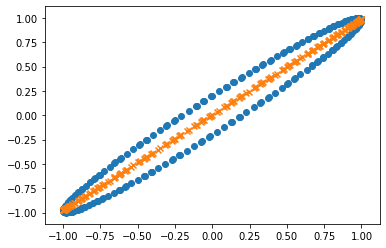

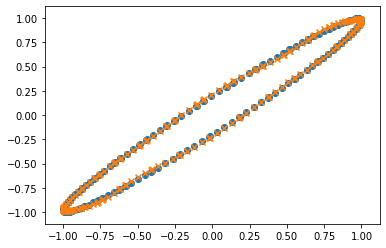

In [112]:
# ## FFN prediction
plt.figure()
plt.scatter(x,y)
out_ffn=ffn.predict(x)
plt.scatter(x,out_ffn,marker='x')

## RNN prediction
plt.figure()
plt.scatter(xx[:,-1],yy)
out_rnn=rnn.predict(xx[:,:,None])
plt.scatter(xx[:,-1],out_rnn,marker='x')



## It is clear that the FFN is hopeless. Given x, it is unable to decide whether to produce the higher or lower y. 
## The RNN knows the past, and therefore can decide whether it is ascending or descending the sine function. 
## Note: this can be achieved with only 2 time steps, no need for 20 (try it at home) 
## Also note: it gets better with more layers (try this now)
---


# Part 3. Predicting the future


### We have been using the input x to predict the output y. But we have not used proper train/test data, so it is cheating. Let's learn how to predict the future data.
### To do this, we need to use the ouput of the network as new input.




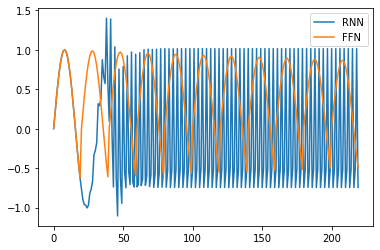

In [113]:

# Get one of the 'batches' as a starting point
x0          = xx[0,:].copy()

# Initialise
current_x   = x0
time_series = x0

# Loop over time points
for i in range(200):
    # make a prediction for the next time point
    pred = rnn.predict(current_x[None,:,None])
    # append
    time_series = np.append(time_series,pred[0])
    # shift 
    current_x[:-1] = current_x[1:]
    current_x[-1] = pred[0]

plt.plot(time_series)

# DO THE SAME FOR FFN
x0 = xx[0,:].copy()
current_x   = x0
time_series = x0
for i in range(200):
    # make a prediction for the next time point
    pred = ffn.predict(current_x)
    # append
    time_series = np.append(time_series,pred[0])
    # shift 
    current_x[:-1] = current_x[1:]
    current_x[-1] = pred[0]


plt.plot(time_series)

plt.legend(('RNN','FFN'))



The RNN is very good at predicting the future of sine. 
The FFN just keeps giving the same first 20 data points repeatedly..










-----

# The end.